In [89]:
import collections
import glob
import json
import os

import numpy as np
import pandas as pd
import pickle
from plotnine import *
import sklearn.metrics
import umap

In [90]:
data_dir = '../../data'
metadata_path = os.path.join(data_dir, 'recount_metadata.tsv')
metadata_df = pd.read_csv(metadata_path, sep='\t')
metadata_df = metadata_df.drop_duplicates()

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3170: DtypeWarning: Columns (11,14,21,22,25,26,29,30,35,36,39,40,41,158,159,166,167,169,170) have mixed types.Specify dtype option on import or set low_memory=False.


In [91]:
metadata_df

,rail_id,external_id,study,sra.sample_acc.x,sra.experiment_acc,sra.submission_acc,sra.submission_center,sra.submission_lab,sra.study_title,sra.study_abstract,...,recount_seq_qc.%n,recount_seq_qc.avgq,recount_seq_qc.errq,recount_pred.sample_acc.y,recount_pred.curated.type,recount_pred.curated.tissue,recount_pred.pattern.predict.type,recount_pred.pred.type,recount_pred.curated.cell_type,recount_pred.curated.cell_line
1,1007887.0,SRR7252610,SRP149665,SRS3369783,SRX4157332,SRA714700,GEO,NaN,Virus Infection Induces Expression of Novel RN...,Innate antiviral immune responses are driven b...,...,0.0,35.8,21.8,SRS3369783,NaN,NaN,rna-seq,rna-seq,NaN,NaN
2,1007903.0,SRR7252611,SRP149665,SRS3369784,SRX4157333,SRA714700,GEO,NaN,Virus Infection Induces Expression of Novel RN...,Innate antiviral immune responses are driven b...,...,0.0,35.3,21,SRS3369784,NaN,NaN,rna-seq,rna-seq,NaN,NaN
3,1007918.0,SRR7252612,SRP149665,SRS3369785,SRX4157334,SRA714700,GEO,NaN,Virus Infection Induces Expression of Novel RN...,Innate antiviral immune responses are driven b...,...,0.0,35.3,21.1,SRS3369785,NaN,NaN,rna-seq,rna-seq,NaN,NaN
4,2015537.0,SRR7252609,SRP149665,SRS3369782,SRX4157331,SRA714700,GEO,NaN,Virus Infection Induces Expression of Novel RN...,Innate antiviral immune responses are driven b...,...,0.0,35.7,21.6,SRS3369782,NaN,NaN,rna-seq,rna-seq,NaN,NaN
5,1004924.0,SRR629557,SRP017465,SRS378921,SRX209056,SRA062599,Human Protein Atlas,Science for Life Lab,RNA sequencing results,RNA sequencing data for human cell lines.,...,0.0,32.8,15.4,SRS378921,NaN,NaN,rna-seq,rna-seq,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341146,NaN,NaN,SRP106855,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
341147,NaN,NaN,SRP103855,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
341148,NaN,NaN,SRP092128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
341149,NaN,NaN,DRP003828,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
sample_to_study = dict(zip(metadata_df['external_id'], metadata_df['study']))

In [93]:
assert sample_to_study['SRR629557'] == 'SRP017465'

In [94]:
label_file = os.path.join(data_dir, 'recount_sample_to_label.pkl')
with open(label_file, 'rb') as in_file:
    sample_to_label = pickle.load(in_file)

In [95]:
metadata_df['label'] = metadata_df['external_id'].map(sample_to_label)

## Load the results from a sample-split experiment

In [96]:
in_files = glob.glob('../../results/sample-split.*.tsv')
print(in_files[:5])

['../../results/sample-split.deep_net_2.tsv', '../../results/sample-split.pytorch_lr_0.tsv', '../../results/sample-split.pytorch_lr_2.tsv', '../../results/sample-split.deep_net_1.tsv', '../../results/sample-split.pytorch_supervised_0.tsv']


In [97]:
tissue_metrics = pd.DataFrame()

for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('biobert.')[-1]
    model_info = model_info.split('.')
    model_info = model_info[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:2])
             
    new_df['supervised'] = supervised_model
    
    new_df['seed'] = model_info[-1]
            
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']
tissue_metrics['supervised'] = tissue_metrics['supervised'].str.replace('pytorch_supervised', 'three_layer_net')

tissue_metrics

,accuracy,balanced_accuracy,train studies,train samples,val samples,train sample count,fraction of data used,is_pretrained,val_predictions,val_true_labels,val_encoders,supervised,seed,train_count
0,0.837668,0.629207,"SRP026042,SRP019989,SRP035665,SRP010061,SRP045...","SRR1012930,SRR364681,SRR925720,DRR006405,SRR24...","ERR356365,SRR031873,ERR789394,SRR1608655,SRR10...",476,0.1,pretrained,"0,0,0,0,9,5,0,6,11,14,12,0,16,14,9,0,0,0,10,4,...","0,0,0,0,9,6,17,6,17,14,12,0,16,14,9,0,0,0,0,15...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",deep_net,2,476
1,0.641779,0.298874,"SRP026042,SRP019989,SRP035665,SRP010061,SRP045...","SRR1012930,SRR364681,SRR925720,DRR006405,SRR24...","ERR356365,SRR031873,ERR789394,SRR1608655,SRR10...",476,0.1,not_pretrained,"0,0,0,0,11,5,16,4,11,11,12,0,0,4,9,0,0,0,4,4,0...","0,0,0,0,9,6,17,6,17,14,12,0,16,14,9,0,0,0,0,15...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",deep_net,2,476
2,0.881711,0.667144,"SRP026042,SRP019989,SRP035665,SRP010061,SRP045...","SRR1012930,SRR364681,SRR925720,DRR006405,SRR24...","ERR356365,SRR031873,ERR789394,SRR1608655,SRR10...",953,0.2,pretrained,"0,0,0,0,9,5,17,6,11,14,12,0,0,14,9,0,0,0,10,4,...","0,0,0,0,9,6,17,6,17,14,12,0,16,14,9,0,0,0,0,15...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",deep_net,2,953
3,0.735738,0.395284,"SRP026042,SRP019989,SRP035665,SRP010061,SRP045...","SRR1012930,SRR364681,SRR925720,DRR006405,SRR24...","ERR356365,SRR031873,ERR789394,SRR1608655,SRR10...",953,0.2,not_pretrained,"0,0,0,0,9,5,17,9,17,5,12,0,0,4,9,0,0,0,4,4,0,1...","0,0,0,0,9,6,17,6,17,14,12,0,16,14,9,0,0,0,0,15...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",deep_net,2,953
4,0.879614,0.674390,"SRP042031,SRP020646,SRP034009,SRP023199,SRP010...","SRR1012930,SRR364681,SRR925720,DRR006405,SRR24...","ERR356365,SRR031873,ERR789394,SRR1608655,SRR10...",1429,0.3,pretrained,"0,0,0,0,9,5,17,6,11,14,12,0,0,4,9,0,0,0,10,4,0...","0,0,0,0,9,6,17,6,17,14,12,0,16,14,9,0,0,0,0,15...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",deep_net,2,1429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.622744,0.230314,"SRP026052,SRP015138,SRP014542,SRP022166,SRP010...","SRR2049710,SRR1015696,SRR189776,SRR830954,ERR3...","SRR1551001,SRR1377150,SRR1036101,SRR1283008,SR...",3813,0.8,not_pretrained,"0,12,0,11,17,0,4,0,4,4,3,0,12,4,4,0,3,4,4,0,12...","0,12,0,20,0,0,3,0,14,7,3,0,12,14,17,16,3,4,4,0...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",three_layer_net,1,3813
96,0.849350,0.548742,"SRP026052,SRP015138,SRP014542,SRP022166,SRP010...","SRR2049710,SRR1015696,SRR189776,SRR830954,ERR3...","SRR1551001,SRR1377150,SRR1036101,SRR1283008,SR...",4290,0.9,pretrained,"0,12,0,11,17,0,17,0,4,11,3,0,12,11,4,16,3,4,4,...","0,12,0,20,0,0,3,0,14,7,3,0,12,14,17,16,3,4,4,0...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",three_layer_net,1,4290
97,0.797734,0.444182,"SRP026052,SRP015138,SRP014542,SRP022166,SRP010...","SRR2049710,SRR1015696,SRR189776,SRR830954,ERR3...","SRR1551001,SRR1377150,SRR1036101,SRR1283008,SR...",4290,0.9,not_pretrained,"0,12,0,11,17,0,3,0,4,11,3,0,12,11,4,0,3,4,4,0,...","0,12,0,20,0,0,3,0,14,7,3,0,12,14,17,16,3,4,4,0...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",three_layer_net,1,4290
98,0.853966,0.560129,"SRP026052,SRP015138,SRP014542,SRP022166,SRP004...","SRR2049710,SRR1015696,SRR189776,SRR830954,ERR3...","SRR1551001,SRR1377150,SRR1036101,SRR1283008,SR...",4767,1.0,pretrained,"0,12,0,11,17,0,4,0,4,11,3,0,12,11,4,16,3,4,4,0...","0,12,0,20,0,0,3,0,14,7,3,0,12,14,17,16,3,4,4,0...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",three_layer_net,1,4767


In [98]:
sample_model_predictions = {}
model_predictions = {}
# Process dataframe rows
for i, row in tissue_metrics[tissue_metrics['is_pretrained'] == 'not_pretrained'].iterrows():
    model = row['supervised']
    
    if model not in model_predictions:
        model_predictions[model] = {'predicted': [], 'true': []}
    
    encoder_string = row['val_encoders']
    encoder = json.loads(encoder_string)
    decoder = {number: label for label, number in encoder.items()}
    
    samples = row['val samples'].strip().split(',')
    
    predictions = row['val_predictions'].strip().split(',')
    truth = row['val_true_labels'].strip().split(',')
    pred_labels = []
    
    for prediction in predictions:
        if int(prediction) in decoder:
            pred_labels.append(decoder[int(prediction)])
        else:
            # https://github.com/greenelab/saged/issues/58
            pred_labels.append('invalid_index')
            
    predictions = pred_labels
    
    truth = [decoder[int(t)] for t in truth]
    
    assert len(truth) == len(predictions)
    
    model_predictions[model]['predicted'].extend(predictions)
    model_predictions[model]['true'].extend(truth)
    
    for sample, prediction, true_label in zip(samples, predictions, truth):
        if sample not in sample_model_predictions:
            sample_model_predictions[sample] = {}
        if model not in sample_model_predictions[sample]:
            sample_model_predictions[sample][model] = {'correct': 0, 'total': 0, 
                                                       'predictions': [], 'true_label': true_label}
        
        assert sample_model_predictions[sample][model]['true_label'] == true_label
        
        sample_model_predictions[sample][model]['predictions'].append(prediction)
        sample_model_predictions[sample][model]['total'] += 1
        
        correct = (prediction == true_label)
        if correct:
            sample_model_predictions[sample][model]['correct'] += 1

In [99]:
# Plot per-model confusion matrices
print(model_predictions.keys())
print(model_predictions['deep_net']['predicted'][:10])
print(model_predictions['deep_net']['true'][:10])

predicted = model_predictions['deep_net']['predicted']
true = model_predictions['deep_net']['true']

confusion_matrix = sklearn.metrics.confusion_matrix(true, predicted, labels=list(encoder.keys()))
confusion_matrix


confusion_df = pd.DataFrame(confusion_matrix, index = [l for l in encoder.keys()],
                            columns = [l for l in encoder.keys()])

dict_keys(['deep_net', 'pytorch_lr', 'three_layer_net', 'logistic_regression'])
['Blood', 'Blood', 'Blood', 'Blood', 'Lung', 'Cervix', 'Spinal Cord', 'Breast', 'Lung', 'Lung']
['Blood', 'Blood', 'Blood', 'Blood', 'Kidney', 'Colon', 'Stem Cell', 'Colon', 'Stem Cell', 'Prostate']


In [100]:
# Rows = True, columns = predicted
confusion_df['true_tissue'] = confusion_df.index
confusion_df

,Blood,Blood Vessel,Bone Marrow,Brain,Breast,Cervix,Colon,Epithelium,Heart,Kidney,...,Muscle,Placenta,Prostate,Skin,Spinal Cord,Stem Cell,Testis,Tonsil,Umbilical Cord,true_tissue
Blood,142527,41,109,286,214,670,3,13,6,276,...,7,8,241,31,322,628,14,298,235,Blood
Blood Vessel,267,109,2,11,77,79,1,13,1,39,...,0,1,20,2,38,218,0,4,111,Blood Vessel
Bone Marrow,3168,0,496,42,155,125,2,9,3,46,...,4,4,126,0,22,20,3,127,76,Bone Marrow
Brain,438,0,187,14340,537,152,1,22,3,138,...,8,7,181,40,105,608,0,14,74,Brain
Breast,181,0,22,662,22764,766,50,11,12,205,...,16,59,690,128,93,212,0,17,53,Breast
Cervix,97,7,61,299,579,15058,5,26,5,159,...,12,13,354,5,35,161,0,0,31,Cervix
Colon,38,0,8,180,552,534,1189,0,9,357,...,0,58,627,8,69,383,0,5,21,Colon
Epithelium,213,39,8,103,560,494,22,433,133,559,...,11,8,223,131,42,206,2,12,86,Epithelium
Heart,379,6,8,77,175,129,1,189,14824,10,...,99,11,326,41,25,178,0,11,60,Heart
Kidney,92,0,13,248,553,765,2,37,70,7414,...,36,13,244,11,111,549,0,12,26,Kidney


In [101]:
melted_df = confusion_df.melt(id_vars='true_tissue', var_name='pred_tissue')
melted_df['log_value'] = np.log(melted_df['value'])

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log


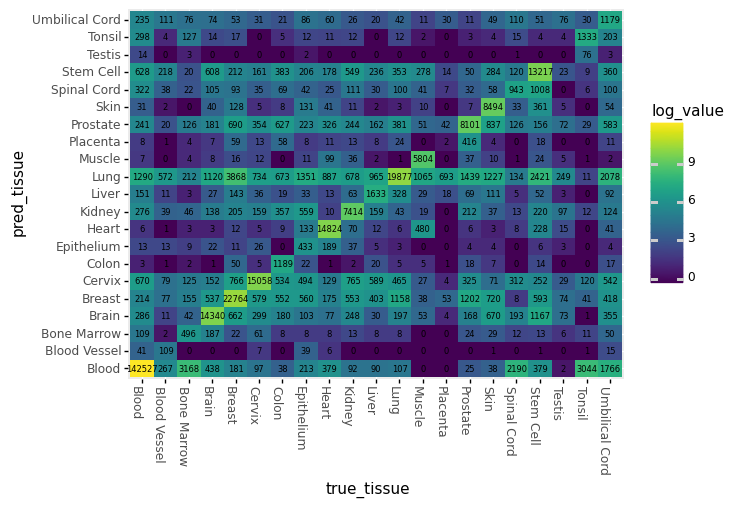

<ggplot: (8752911904121)>

In [102]:
plot = ggplot(melted_df, aes(x='true_tissue', y='pred_tissue', fill='log_value',)) 
plot += geom_tile() 
plot += geom_text(aes(label='value'), size=6)
plot += theme(axis_text_x=element_text(rotation=270, hjust=1))
plot

In [103]:
# TODO replace counts in melted_df with percent of that label?

In [104]:
# sample_model_predictions[sample][model]['total'] += 1
# sample_model_predictions[sample][model]['correct']

data_dict_list = []

for sample in sample_model_predictions:
    data_dict = {}
    data_dict['sample'] = sample
    for model in sample_model_predictions[sample]:
        total = sample_model_predictions[sample][model]['total']
        correct = sample_model_predictions[sample][model]['correct']
        acc = correct / total
        percent_wrong = 100 * (1 - acc)
        
        data_dict['{}_total'.format(model)] =  total 
        data_dict['{}_correct'.format(model)] = correct
        data_dict['{}_acc'.format(model)] = acc
        data_dict['{}_percent_wrong'.format(model)] = percent_wrong
    data_dict_list.append(data_dict)
        
acc_df = pd.DataFrame(data_dict_list)

In [105]:

acc_df

,sample,deep_net_total,deep_net_correct,deep_net_acc,deep_net_percent_wrong,pytorch_lr_total,pytorch_lr_correct,pytorch_lr_acc,pytorch_lr_percent_wrong,three_layer_net_total,three_layer_net_correct,three_layer_net_acc,three_layer_net_percent_wrong,logistic_regression_total,logistic_regression_correct,logistic_regression_acc,logistic_regression_percent_wrong
0,ERR356365,30,30,1.000000,0.000000,30,30,1.000000,0.000000,30,30,1.000000,0.000000,30,30,1.0,0.0
1,SRR031873,30,30,1.000000,0.000000,30,30,1.000000,0.000000,30,30,1.000000,0.000000,30,30,1.0,0.0
2,ERR789394,30,30,1.000000,0.000000,30,30,1.000000,0.000000,30,30,1.000000,0.000000,30,30,1.0,0.0
3,SRR1608655,30,30,1.000000,0.000000,30,30,1.000000,0.000000,30,30,1.000000,0.000000,30,30,1.0,0.0
4,SRR1038623,30,26,0.866667,13.333333,30,22,0.733333,26.666667,30,12,0.400000,60.000000,30,30,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11913,SRR1035698,30,27,0.900000,10.000000,30,29,0.966667,3.333333,30,26,0.866667,13.333333,30,30,1.0,0.0
11914,SRR857238,30,0,0.000000,100.000000,30,0,0.000000,100.000000,30,0,0.000000,100.000000,30,0,0.0,100.0
11915,SRR1054290,30,24,0.800000,20.000000,30,22,0.733333,26.666667,30,7,0.233333,76.666667,30,30,1.0,0.0
11916,SRR1027468,30,0,0.000000,100.000000,30,0,0.000000,100.000000,30,0,0.000000,100.000000,30,0,0.0,100.0


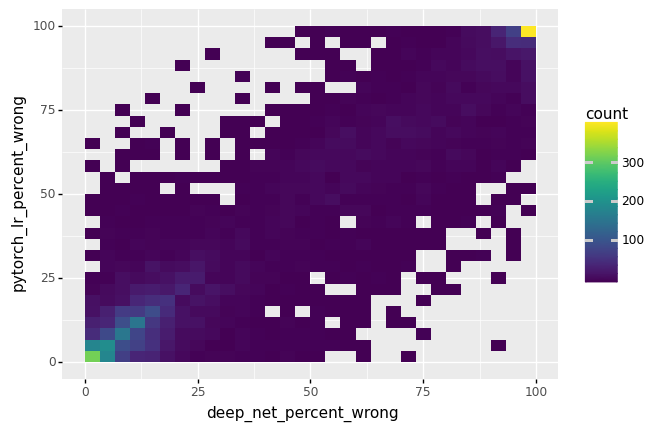

<ggplot: (8752911904705)>

In [106]:
plot = ggplot(acc_df, aes(x='deep_net_percent_wrong', y='pytorch_lr_percent_wrong'))
plot += geom_bin2d()
plot

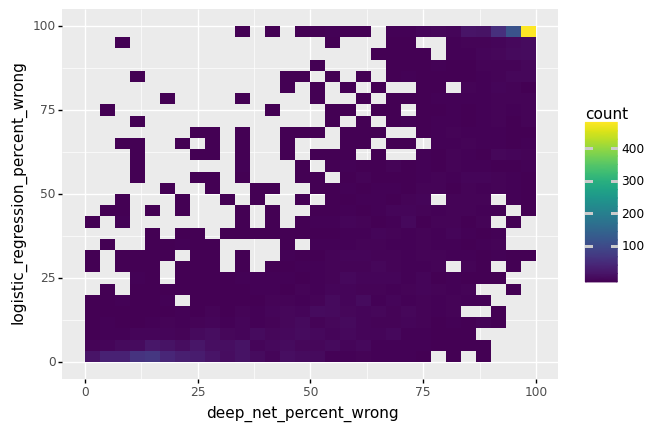

<ggplot: (8753007147013)>

In [107]:
plot = ggplot(acc_df, aes(x='deep_net_percent_wrong', y='logistic_regression_percent_wrong'))
plot += geom_bin2d()
plot

In [108]:
# Collect all samples misclassified by all models in every case
hard_samples = []
for sample in sample_model_predictions:
    good_prediction = False
    for model in sample_model_predictions[sample]:
        correct = sample_model_predictions[sample][model]['correct']
        if correct > 0:
            good_prediction = True
    
    if not good_prediction:
        hard_samples.append(sample)

In [109]:
print(len(hard_samples))

studies = set([sample_to_study[sample] for sample in hard_samples])
print(len(studies))

print(studies)

349
119
{'SRP005281', 'SRP028902', 'SRP029452', 'SRP041263', 'SRP019374', 'SRP010166', 'SRP028804', 'SRP035477', 'SRP028118', 'SRP038761', 'SRP023233', 'SRP028594', 'SRP017843', 'SRP007881', 'SRP033491', 'SRP007359', 'SRP031478', 'SRP015361', 'SRP021916', 'SRP008746', 'SRP033711', 'SRP012099', 'SRP003754', 'SRP041367', 'SRP027514', 'SRP044303', 'SRP036790', 'SRP009386', 'SRP012098', 'SRP021524', 'SRP007461', 'SRP040694', 'SRP022025', 'SRP028336', 'SRP011085', 'SRP004637', 'SRP009474', 'SRP014688', 'SRP038759', 'SRP021912', 'SRP003227', 'SRP019807', 'SRP026084', 'SRP023270', 'SRP014487', 'SRP044668', 'SRP038101', 'SRP032922', 'SRP019207', 'SRP017199', 'SRP019810', 'SRP021214', 'SRP018028', 'SRP020556', 'SRP041988', 'SRP017019', 'SRP010907', 'SRP018883', 'SRP012557', 'SRP016059', 'SRP017378', 'SRP015640', 'SRP028554', 'SRP005242', 'SRP023111', 'SRP042184', 'SRP020646', 'SRP015761', 'SRP014906', 'SRP039591', 'SRP019961', 'SRP011927', 'SRP013450', 'SRP040692', 'SRP012295', 'SRP007412', 'SR

In [110]:
print(hard_samples[:5])

['SRR901292', 'SRR1057941', 'SRR423929', 'SRR771240', 'SRR786804']


### Are all samples in a study with hard samples unclassifiable?

In [111]:
samples_in_bad_studies = 0
for sample, study in sample_to_study.items():
    if study in studies:
        samples_in_bad_studies += 1

print(len(hard_samples), samples_in_bad_studies, len(hard_samples) / samples_in_bad_studies)

349 2485 0.14044265593561367


For each sample that is universally incorrectly classified, there are six other in the same study that are fine

### Are there any hints in the metadata about why the samples are hard to classify?

In [112]:
metadata_df = metadata_df.set_index('external_id')

In [113]:
metadata_df = metadata_df[metadata_df.index.notnull()]

In [114]:
for col in metadata_df.columns:
    print(col)

rail_id
study
sra.sample_acc.x
sra.experiment_acc
sra.submission_acc
sra.submission_center
sra.submission_lab
sra.study_title
sra.study_abstract
sra.study_description
sra.experiment_title
sra.design_description
sra.sample_description
sra.library_name
sra.library_strategy
sra.library_source
sra.library_selection
sra.library_layout
sra.paired_nominal_length
sra.paired_nominal_stdev
sra.library_construction_protocol
sra.platform_model
sra.sample_attributes
sra.experiment_attributes
sra.spot_length
sra.sample_name
sra.sample_title
sra.sample_bases
sra.sample_spots
sra.run_published
sra.size
sra.run_total_bases
sra.run_total_spots
sra.num_reads
sra.num_spots
sra.read_info
sra.run_alias
sra.run_center_name
sra.run_broker_name
sra.run_center
recount_project.project
recount_project.organism
recount_project.file_source
recount_project.metadata_source
recount_project.date_processed
recount_qc.aligned_reads%.chrm
recount_qc.aligned_reads%.chrx
recount_qc.aligned_reads%.chry
recount_qc.bc_auc.all_

In [115]:
hard_sample_df = metadata_df.loc[hard_samples]
hard_sample_df

,rail_id,study,sra.sample_acc.x,sra.experiment_acc,sra.submission_acc,sra.submission_center,sra.submission_lab,sra.study_title,sra.study_abstract,sra.study_description,...,recount_seq_qc.avgq,recount_seq_qc.errq,recount_pred.sample_acc.y,recount_pred.curated.type,recount_pred.curated.tissue,recount_pred.pattern.predict.type,recount_pred.pred.type,recount_pred.curated.cell_type,recount_pred.curated.cell_line,label
external_id,,,,,,,,,,,,,,,,,,,,,
SRR901292,1856092.0,SRP026044,SRS445234,SRX306189,SRA091125,GEO,NaN,Multiple roles for LEC in initiation and elong...,The small nuclear RNA (snRNA) genes have been ...,NaN,...,36.5,22.8,SRS445234,NaN,Colon,rna-seq,rna-seq,NaN,NaN,Colon
SRR1057941,1086490.0,SRP020556,SRS518954,SRX398502,SRA072653,GEO,NaN,Genome-wide probing of RNA structure reveals a...,We present an approach for globally monitoring...,NaN,...,36.9,21.2,SRS518954,NaN,Bone Marrow,rna-seq,rna-seq,NaN,NaN,Bone Marrow
SRR423929,510287.0,SRP011085,SRS295689,SRX124473,SRA050382,UMIGS,Genomics Resource Core,Characterization of transcriptome dynamics in ...,Candida albicans is the major invasive fungal ...,NaN,...,30.3,11.3,SRS295689,NaN,Heart,rna-seq,rna-seq,NaN,NaN,Heart
SRR771240,3182626.0,SRP019222,SRS400402,SRX248288,SRA068903,GEO,NaN,Epstein-Barr virus maintains lymphomas via its...,Epstein-Barr virus (EBV) has evolved exquisite...,NaN,...,38.1,22.5,SRS400402,NaN,Epithelium,rna-seq,scrna-seq,NaN,NaN,Epithelium
SRR786804,1507484.0,SRP001371,SRS373351,SRX252257,SRA010036,GEO,NaN,University of Washington Human Reference Epige...,Study of chromatin accessibility,"For data usage terms and conditions, please re...",...,37.5,18.2,SRS373351,rna-seq,Spinal Cord,rna-seq,rna-seq,NaN,NaN,Spinal Cord
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR502784,686154.0,SRP013450,SRS336155,SRX150767,SRA053324,GEO,NaN,Study functions of ADAR proteins using next ge...,"Adenosine deaminases, RNA specific (ADAR) are ...",NaN,...,34.5,15.2,SRS336155,NaN,Tonsil,rna-seq,rna-seq,NaN,NaN,Tonsil
SRR857239,2115387.0,SRP022876,SRS424518,SRX282062,SRA079868,GEO,NaN,Differential gene expression by suppression of...,SOX2 is a transcription factor essential for p...,NaN,...,33.4,16,SRS424518,NaN,Stem Cell,rna-seq,scrna-seq,NaN,NaN,Stem Cell
SRR650430,2393624.0,SRP018028,SRS386365,SRX218318,SRA065153,GEO,NaN,Differential gene expression and exon usage in...,"SF3B1, splicing factor 3b subunit 1 is a compo...",NaN,...,31.6,14.1,SRS386365,NaN,Bone Marrow,rna-seq,scrna-seq,NaN,NaN,Bone Marrow


In [116]:
metadata_df['recount_seq_qc.avgq'] = pd.to_numeric(metadata_df['recount_seq_qc.avgq'], errors='coerce')
metadata_df = metadata_df[metadata_df['recount_seq_qc.avgq'].notnull()]
metadata_df

,rail_id,study,sra.sample_acc.x,sra.experiment_acc,sra.submission_acc,sra.submission_center,sra.submission_lab,sra.study_title,sra.study_abstract,sra.study_description,...,recount_seq_qc.avgq,recount_seq_qc.errq,recount_pred.sample_acc.y,recount_pred.curated.type,recount_pred.curated.tissue,recount_pred.pattern.predict.type,recount_pred.pred.type,recount_pred.curated.cell_type,recount_pred.curated.cell_line,label
external_id,,,,,,,,,,,,,,,,,,,,,
SRR7252610,1007887.0,SRP149665,SRS3369783,SRX4157332,SRA714700,GEO,NaN,Virus Infection Induces Expression of Novel RN...,Innate antiviral immune responses are driven b...,NaN,...,35.8,21.8,SRS3369783,NaN,NaN,rna-seq,rna-seq,NaN,NaN,NaN
SRR7252611,1007903.0,SRP149665,SRS3369784,SRX4157333,SRA714700,GEO,NaN,Virus Infection Induces Expression of Novel RN...,Innate antiviral immune responses are driven b...,NaN,...,35.3,21,SRS3369784,NaN,NaN,rna-seq,rna-seq,NaN,NaN,NaN
SRR7252612,1007918.0,SRP149665,SRS3369785,SRX4157334,SRA714700,GEO,NaN,Virus Infection Induces Expression of Novel RN...,Innate antiviral immune responses are driven b...,NaN,...,35.3,21.1,SRS3369785,NaN,NaN,rna-seq,rna-seq,NaN,NaN,NaN
SRR7252609,2015537.0,SRP149665,SRS3369782,SRX4157331,SRA714700,GEO,NaN,Virus Infection Induces Expression of Novel RN...,Innate antiviral immune responses are driven b...,NaN,...,35.7,21.6,SRS3369782,NaN,NaN,rna-seq,rna-seq,NaN,NaN,NaN
SRR629557,1004924.0,SRP017465,SRS378921,SRX209056,SRA062599,Human Protein Atlas,Science for Life Lab,RNA sequencing results,RNA sequencing data for human cell lines.,NaN,...,32.8,15.4,SRS378921,NaN,NaN,rna-seq,rna-seq,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR7516583,4808929.0,SRP153228,SRS3542937,SRX4386623,SRA738704,GEO,NaN,lncRNA expression analysis in patients with eo...,Long non-coding RNA (lncRNA) are known to be i...,NaN,...,39.2,28.8,SRS3542937,NaN,NaN,rna-seq,scrna-seq,NaN,NaN,NaN
SRR7516584,4808992.0,SRP153228,SRS3542950,SRX4386624,SRA738704,GEO,NaN,lncRNA expression analysis in patients with eo...,Long non-coding RNA (lncRNA) are known to be i...,NaN,...,38.6,27.6,SRS3542950,NaN,NaN,rna-seq,scrna-seq,NaN,NaN,NaN
SRR7516586,4809120.0,SRP153228,SRS3542952,SRX4386626,SRA738704,GEO,NaN,lncRNA expression analysis in patients with eo...,Long non-coding RNA (lncRNA) are known to be i...,NaN,...,39.0,27.9,SRS3542952,NaN,NaN,rna-seq,scrna-seq,NaN,NaN,NaN


<AxesSubplot:title={'center':'AvgQ Distributon'}, ylabel='Frequency'>

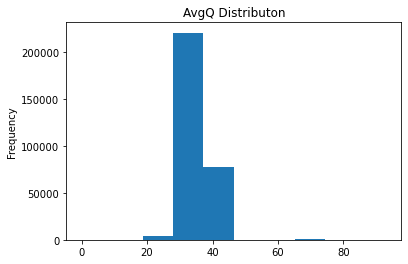

In [117]:
metadata_df['recount_seq_qc.avgq'] = metadata_df['recount_seq_qc.avgq'].astype(float)
metadata_df['recount_seq_qc.avgq'].plot.hist(title='AvgQ Distributon')

<AxesSubplot:title={'center':'AvgQ Distributon in Hard Samples'}, ylabel='Frequency'>

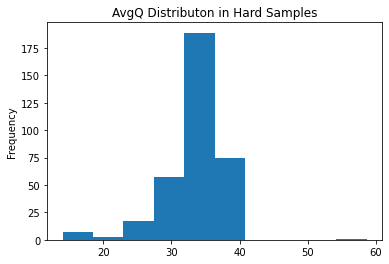

In [118]:
hard_sample_df['recount_seq_qc.avgq'] = hard_sample_df['recount_seq_qc.avgq'].astype(float)
hard_sample_df['recount_seq_qc.avgq'].plot.hist(title='AvgQ Distributon in Hard Samples')

<AxesSubplot:title={'center':'AvgQ Distributon'}, ylabel='Frequency'>

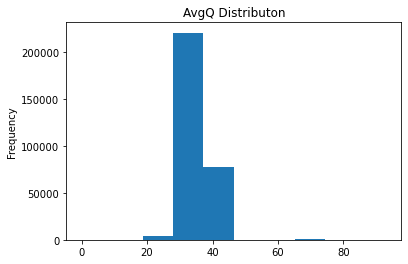

In [119]:
metadata_df['recount_seq_qc.errq'] = metadata_df['recount_seq_qc.avgq'].astype(float)
metadata_df['recount_seq_qc.errq'].plot.hist(title='AvgQ Distributon')

<AxesSubplot:title={'center':'AvgQ Distributon in Hard Samples'}, ylabel='Frequency'>

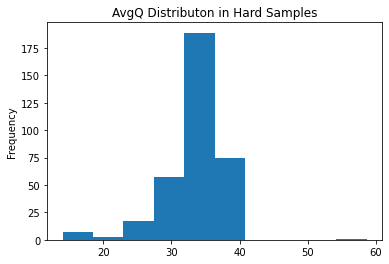

In [120]:
hard_sample_df['recount_seq_qc.errq'] = hard_sample_df['recount_seq_qc.avgq'].astype(float)
hard_sample_df['recount_seq_qc.errq'].plot.hist(title='AvgQ Distributon in Hard Samples')

In [121]:
# TODO maybe run UMAP and see if the hard sample cluster together or something?
# TODO is it sparsity?
# TODO is there a relationship between bad samples and one of the classes?
# TODO basically, is there a predictable relationship between bad samples so that we can remove them or learn what causes them?

## Do the hard samples stand out in a UMAP embedding?

In [122]:
expression_df = pd.read_pickle("../../data/no_scrna_tpm.pkl")

In [123]:
# Running UMAP on 200k samples just makes a giant oval
is_hard = [sample in hard_samples for sample in expression_df.index]
expression_df['is_hard'] = is_hard

easy_df = expression_df[expression_df['is_hard'] == False]
easy_df = easy_df.sample(n=4000, random_state=42)
hard_df = expression_df[expression_df['is_hard']]
sampled_df = pd.concat([easy_df, hard_df])

# Remove column to extract expression for UMAP
is_hard = sampled_df['is_hard']
sampled_df = sampled_df.drop(['is_hard'], axis='columns')

sampled_df

,ENSG00000253132.1,ENSG00000172465.13,ENSG00000206013.2,ENSG00000214866.8,ENSG00000270390.1,ENSG00000235447.2,ENSG00000108602.17,ENSG00000279997.1,ENSG00000267112.1,ENSG00000234670.1,...,ENSG00000242960.1,ENSG00000274029.1,ENSG00000201945.1,ENSG00000121440.14,ENSG00000229616.2,ENSG00000088992.17,ENSG00000240964.3,ENSG00000111906.17,ENSG00000128596.16,ENSG00000255575.1
sample,,,,,,,,,,,,,,,,,,,,,
ERR2928074,0.0,0.0,0.086609,0.000000,0.001747,0.000000,0.000000,0.014992,0.024307,0.000322,...,0.000000,0.000000,0.139160,0.000000,2.760887e-04,0.070190,0.000000,0.000760,0.009590,0.000000
SRR5960243,0.0,0.0,0.006512,0.018265,0.005875,0.000000,0.000114,0.021912,0.011314,0.000137,...,0.002022,0.000014,0.056488,0.000000,9.757280e-05,0.043365,0.000000,0.002110,0.001748,0.000000
SRR6503121,0.0,0.0,0.002462,0.024689,0.000000,0.000185,0.000000,0.007607,0.000983,0.003275,...,0.004818,0.000000,0.008347,0.000055,1.527071e-04,0.032440,0.000000,0.000219,0.002331,0.000114
SRR6244049,0.0,0.0,0.003803,0.129517,0.000890,0.000000,0.000000,0.009872,0.000202,0.000427,...,0.102600,0.000000,0.017792,0.000354,2.980232e-07,0.063660,0.000043,0.007046,0.006474,0.000000
SRR7961364,0.0,0.0,0.017517,0.000000,0.000000,0.000000,0.000000,0.032837,0.000597,0.000703,...,0.000125,0.000000,0.122742,0.000296,3.474951e-05,0.019257,0.000000,0.000761,0.037354,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR952670,0.0,0.0,0.000379,0.006214,0.000000,0.000000,0.000000,0.006786,0.008171,0.001471,...,0.002861,0.000000,0.003365,0.000921,0.000000e+00,0.008865,0.000000,0.000097,0.000571,0.000000
SRR1248269,0.0,0.0,0.039215,0.011261,0.007679,0.000000,0.000000,0.025192,0.000638,0.001044,...,0.057739,0.000000,0.187744,0.000000,4.005432e-05,0.049438,0.000000,0.003405,0.034576,0.000000
SRR650429,0.0,0.0,0.007530,0.005150,0.002724,0.000011,0.000000,0.020569,0.000039,0.001187,...,0.080566,0.000000,0.023178,0.003080,7.808208e-06,0.373047,0.000000,0.001092,0.001447,0.000000


In [124]:
expression_matrix = sampled_df.to_numpy()
expression_matrix.shape

(4349, 5000)

In [125]:
reducer = umap.UMAP(transform_seed=42, random_state=42, n_components=2)

In [126]:
%%time
expression_umap = reducer.fit_transform(expression_matrix)

CPU times: user 12.7 s, sys: 287 ms, total: 13 s
Wall time: 7.37 s


In [127]:
umap_df = pd.DataFrame(expression_umap, index=sampled_df.index, columns=['UMAP1', 'UMAP2'])

In [128]:
umap_df

,UMAP1,UMAP2
sample,,
ERR2928074,-2.529983,4.744152
SRR5960243,-4.952123,3.587344
SRR6503121,-2.473183,-2.304391
SRR6244049,4.636759,-2.606193
SRR7961364,-0.551636,8.541205
...,...,...
SRR952670,-2.515734,-2.965608
SRR1248269,2.004352,0.804530
SRR650429,4.320385,-0.367934


In [129]:
umap_df['is_hard'] = is_hard

In [130]:
assert umap_df.loc['SRR1057941']['is_hard']

In [131]:
umap_df

,UMAP1,UMAP2,is_hard
sample,,,
ERR2928074,-2.529983,4.744152,False
SRR5960243,-4.952123,3.587344,False
SRR6503121,-2.473183,-2.304391,False
SRR6244049,4.636759,-2.606193,False
SRR7961364,-0.551636,8.541205,False
...,...,...,...
SRR952670,-2.515734,-2.965608,True
SRR1248269,2.004352,0.804530,True
SRR650429,4.320385,-0.367934,True


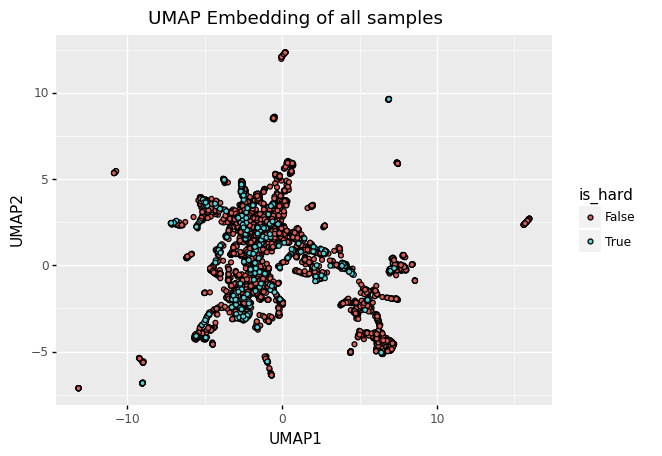

<ggplot: (8752882661337)>


In [132]:
plot = ggplot(umap_df, aes(x='UMAP1', y='UMAP2', fill='is_hard'))
plot += geom_point()
plot += ggtitle('UMAP Embedding of all samples')
print(plot)

## Do the hard samples stand out compared to other samples with the same label?

In [133]:
hard_sample_df['label'].value_counts()

Bone Marrow       56
Umbilical Cord    53
Epithelium        48
Heart             38
Skin              26
Brain             19
Liver             17
Tonsil            15
Stem Cell         15
Spinal Cord       11
Colon             11
Kidney             7
Cervix             6
Placenta           5
Breast             5
Muscle             5
Blood Vessel       4
Testis             4
Prostate           3
Lung               1
Name: label, dtype: int64

In [134]:
metadata_df['label'].value_counts()

Blood                  5179
Glioblastoma           1144
Breast                 1057
Lung                    803
Stem Cell               719
Brain                   702
Cervix                  686
Universal reference     599
Heart                   589
Kidney                  587
Brain reference         560
Large Intestine         534
SEQC_C                  484
SEQC_D                  483
Adipose Tissue          453
Skin                    446
Prostate                438
Umbilical Cord          287
Muscle                  276
Melanoma                243
Epithelium              218
Colon                   194
Pancreas                180
Tonsil                  171
Liver                   164
Bone Marrow             163
Placenta                157
Spinal Cord             145
Thymus                  116
Bone                     83
Bladder                  63
Blood Vessel             59
Airway                   52
Embryonic kidney         49
Small Intestine          46
Testis              

The samples that are consistently mislabeled tend to be from the less common classes.

Potential causes:
1. There are fewer studies for those samples, so the inter-study differences are stronger (shouldn't be the case though since we're looking at an example with built-in leakage of study info between train and test sets)
2. There are fewer samples for the classes the hard samples are drawn from, so they are inherently harder predicton problems
3. Class imbalance causes these classes to consistently be predicted to be one of the more common classes (possibly in addition to the above)
4. Some samples may just be different from other samples in their class due to technical noise or vague labels

In [135]:
expression_df = expression_df.drop('is_hard', axis='columns')
is_hard = [sample in hard_samples for sample in metadata_df.index]
metadata_df['is_hard'] = is_hard

## Are the hard samples study-specific?

In [150]:
# Num samples per study
metadata_df[metadata_df['label'] == 'Bone Marrow'].groupby('study').count()['is_hard']

study
DRP001219     1
DRP001220     1
ERP003613     8
SRP003754     2
SRP005279    27
SRP007461     2
SRP007881     8
SRP009840    19
SRP015439     2
SRP018028     3
SRP020556     8
SRP022025     3
SRP028554     4
SRP028594    23
SRP028912     8
SRP033266    14
SRP041036    30
Name: is_hard, dtype: int64

In [151]:
# Num hard samples per study
metadata_df[metadata_df['label'] == 'Bone Marrow'].groupby('study').sum()['is_hard']

study
DRP001219     0.0
DRP001220     0.0
ERP003613     3.0
SRP003754     0.0
SRP005279     0.0
SRP007461     2.0
SRP007881     5.0
SRP009840     0.0
SRP015439     2.0
SRP018028     3.0
SRP020556     1.0
SRP022025     1.0
SRP028554     4.0
SRP028594    20.0
SRP028912     7.0
SRP033266     8.0
SRP041036     0.0
Name: is_hard, dtype: float64

In [174]:
metadata_df[(metadata_df['study'] == 'SRP028912') & (metadata_df['label'] == 'Bone Marrow')]

,rail_id,study,sra.sample_acc.x,sra.experiment_acc,sra.submission_acc,sra.submission_center,sra.submission_lab,sra.study_title,sra.study_abstract,sra.study_description,...,recount_pred.sample_acc.y,recount_pred.curated.type,recount_pred.curated.tissue,recount_pred.pattern.predict.type,recount_pred.pred.type,recount_pred.curated.cell_type,recount_pred.curated.cell_line,label,is_hard,numeric_is_hard
external_id,,,,,,,,,,,,,,,,,,,,,
SRR954235,3181926.0,SRP028912,SRS471484,SRX336853,SRA098175,GEO,NaN,SnapShot-Seq: a method for extracting genome-w...,"mRNA synthesis, processing, and destruction in...",NaN,...,SRS471484,NaN,Bone Marrow,rna-seq,rna-seq,NaN,NaN,Bone Marrow,True,True
SRR954236,3181991.0,SRP028912,SRS471485,SRX336854,SRA098175,GEO,NaN,SnapShot-Seq: a method for extracting genome-w...,"mRNA synthesis, processing, and destruction in...",NaN,...,SRS471485,NaN,Bone Marrow,rna-seq,rna-seq,NaN,NaN,Bone Marrow,True,True
SRR954237,3182053.0,SRP028912,SRS471486,SRX336855,SRA098175,GEO,NaN,SnapShot-Seq: a method for extracting genome-w...,"mRNA synthesis, processing, and destruction in...",NaN,...,SRS471486,NaN,Bone Marrow,rna-seq,rna-seq,NaN,NaN,Bone Marrow,True,True
SRR954238,3182120.0,SRP028912,SRS471487,SRX336856,SRA098175,GEO,NaN,SnapShot-Seq: a method for extracting genome-w...,"mRNA synthesis, processing, and destruction in...",NaN,...,SRS471487,NaN,Bone Marrow,rna-seq,NaN,NaN,NaN,Bone Marrow,True,True
SRR954239,3182185.0,SRP028912,SRS471488,SRX336857,SRA098175,GEO,NaN,SnapShot-Seq: a method for extracting genome-w...,"mRNA synthesis, processing, and destruction in...",NaN,...,SRS471488,NaN,Bone Marrow,rna-seq,NaN,NaN,NaN,Bone Marrow,True,True
SRR954240,3182632.0,SRP028912,SRS471489,SRX336858,SRA098175,GEO,NaN,SnapShot-Seq: a method for extracting genome-w...,"mRNA synthesis, processing, and destruction in...",NaN,...,SRS471489,NaN,Bone Marrow,rna-seq,rna-seq,NaN,NaN,Bone Marrow,True,True
SRR954241,3182697.0,SRP028912,SRS471490,SRX336859,SRA098175,GEO,NaN,SnapShot-Seq: a method for extracting genome-w...,"mRNA synthesis, processing, and destruction in...",NaN,...,SRS471490,NaN,Bone Marrow,rna-seq,rna-seq,NaN,NaN,Bone Marrow,False,False
SRR954242,3182760.0,SRP028912,SRS471491,SRX336860,SRA098175,GEO,NaN,SnapShot-Seq: a method for extracting genome-w...,"mRNA synthesis, processing, and destruction in...",NaN,...,SRS471491,NaN,Bone Marrow,rna-seq,rna-seq,NaN,NaN,Bone Marrow,True,True


### Manual inspection
I looked at each of bone marrow studies to see if anything stood out:

| study | samples | hard samples | notes |
| ----- | ------  | ------------ | ----- |
DRP001219  |   1 | 0 | Child leukemia study |
DRP001220  |   1 | 0 | Child leukemia study (run by same group as above) |
ERP003613  |   8 | 3 | Healthy tissue; Swedish biobank |
SRP003754  |   2 | 0 | Actually pluripotent epithelial cells |
SRP005279  |  27 | 0 | Mixture of ALL (leukemuia) and healthy samples |
SRP007461  |   2 | 2 | ENCODE HMSC-bm (bone marrow) |
SRP007881  |   8 | 5 | Prostate cancer bone mestastases |
SRP009840  |  19 | 0 | Childhood ALL |
SRP015439  |   2 | 2 | Amniotic cells reprogrammed into endothelial cells |
SRP018028  |   3 | 3 | Healthy and RARS (leukemia precursor) patients' bone marrow |
SRP020556  |   8 | 1 | Leukemic Bone marrow |
SRP022025  |   3 |  1 | Leukemic blasts and promyelocytes |
SRP028554  |   4 | 4 | Leukemic bone marrow |
SRP028594  |  23 |20 | AML samples from bone marrow (half the samples in the study are blood though) |
SRP028912  |   8 | 7 | Lymphocyte cell lines |
SRP033266  |  14 | 8 | AML bone marrow |
SRP041036  |  30 | 0 | Bone marrow + chemo drugs |

## Do the hard samples show up on a UMAP?

In [136]:
expression_samples = set(expression_df.index)

marrow_df = metadata_df[metadata_df['label'] == 'Bone Marrow']
marrow_samples = [sample for sample in marrow_df.index if sample in expression_samples]

marrow_expression = expression_df.loc[marrow_samples]

assert 'SRR954235' in hard_samples
assert 'SRR650431' in hard_samples

marrow_expression

,ENSG00000253132.1,ENSG00000172465.13,ENSG00000206013.2,ENSG00000214866.8,ENSG00000270390.1,ENSG00000235447.2,ENSG00000108602.17,ENSG00000279997.1,ENSG00000267112.1,ENSG00000234670.1,...,ENSG00000242960.1,ENSG00000274029.1,ENSG00000201945.1,ENSG00000121440.14,ENSG00000229616.2,ENSG00000088992.17,ENSG00000240964.3,ENSG00000111906.17,ENSG00000128596.16,ENSG00000255575.1
sample,,,,,,,,,,,,,,,,,,,,,
SRR954235,0.0,0.0,0.011574,0.003437,0.002153,0.000107,0.0,0.015266,0.004292,0.004070,...,0.040741,0.000000,0.047058,0.000000,0.000000,0.009941,0.000049,0.009041,0.020416,0.0
SRR954236,0.0,0.0,0.013939,0.004677,0.001686,0.000000,0.0,0.013771,0.004723,0.004120,...,0.040436,0.000000,0.038910,0.000006,0.000006,0.011070,0.000072,0.007763,0.009247,0.0
SRR954237,0.0,0.0,0.015366,0.002777,0.002243,0.000000,0.0,0.014404,0.004669,0.004322,...,0.038605,0.000002,0.040588,0.000000,0.000000,0.012726,0.000062,0.009178,0.009819,0.0
SRR954238,0.0,0.0,0.006714,0.004467,0.004368,0.000389,0.0,0.004280,0.001419,0.000399,...,0.056305,0.000000,0.035095,0.000000,0.000019,0.034760,0.001114,0.014984,0.011131,0.0
SRR954239,0.0,0.0,0.006714,0.004467,0.004368,0.000389,0.0,0.004280,0.001419,0.000399,...,0.056305,0.000000,0.035095,0.000000,0.000019,0.034760,0.001114,0.014984,0.011131,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR091671,0.0,0.0,0.017502,0.030807,0.000000,0.000000,0.0,0.000273,0.000058,0.030701,...,0.040985,0.000000,0.005947,0.000013,0.000007,0.000035,0.000000,0.018448,0.008270,0.0
SRR091672,0.0,0.0,0.000000,0.060760,0.000000,0.000000,0.0,0.000000,0.001115,1.000000,...,0.018829,0.000000,0.017578,0.000000,0.003250,0.000000,0.000000,0.000000,0.000771,0.0
SRR650429,0.0,0.0,0.007530,0.005150,0.002724,0.000011,0.0,0.020569,0.000039,0.001187,...,0.080566,0.000000,0.023178,0.003080,0.000008,0.373047,0.000000,0.001092,0.001447,0.0


In [153]:
expression_matrix = marrow_expression.to_numpy()

In [154]:
reducer = umap.UMAP(transform_seed=42, random_state=42, n_components=2)
marrow_umap = reducer.fit_transform(expression_matrix)

In [157]:
umap_df = pd.DataFrame(marrow_umap, columns=['UMAP1', 'UMAP2'], index=marrow_expression.index)
umap_df

,UMAP1,UMAP2
sample,,
SRR954235,5.809420,5.610249
SRR954236,5.715117,5.775803
SRR954237,5.671032,5.733752
SRR954238,5.367182,5.330960
SRR954239,5.248573,5.212049
...,...,...
SRR091671,10.052425,8.127967
SRR091672,8.291703,5.056062
SRR650429,13.451515,4.685084


In [194]:
is_hard = [sample in hard_samples for sample in umap_df.index]
umap_df['is_hard'] = is_hard
umap_df['study'] = metadata_df.loc[umap_df.index]['study']
umap_df['platform'] = metadata_df.loc[umap_df.index]['sra.platform_model']
umap_df['date'] = metadata_df.loc[umap_df.index]['sra.run_published']


umap_df

,UMAP1,UMAP2,is_hard,study,platform,date
sample,,,,,,
SRR954235,5.809420,5.610249,True,SRP028912,Illumina HiSeq 2000,2014-02-04 15:21:08
SRR954236,5.715117,5.775803,True,SRP028912,Illumina HiSeq 2000,2014-02-04 15:21:08
SRR954237,5.671032,5.733752,True,SRP028912,Illumina HiSeq 2000,2014-02-04 15:21:08
SRR954238,5.367182,5.330960,True,SRP028912,Illumina HiSeq 2000,2015-07-22 17:06:04
SRR954239,5.248573,5.212049,True,SRP028912,Illumina HiSeq 2000,2015-07-22 17:06:04
...,...,...,...,...,...,...
SRR091671,10.052425,8.127967,False,SRP005279,Illumina Genome Analyzer II,2011-12-21 09:09:34
SRR091672,8.291703,5.056062,False,SRP005279,Illumina Genome Analyzer II,2011-12-21 09:09:34
SRR650429,13.451515,4.685084,True,SRP018028,Illumina HiSeq 2000,2015-07-22 17:03:21


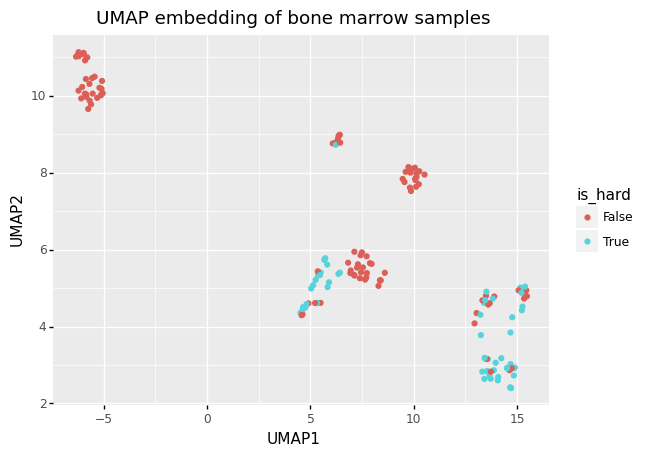

<ggplot: (8752833056045)>


In [162]:
plot = ggplot(umap_df, aes(x='UMAP1', y='UMAP2', color='is_hard'))
plot += geom_point()
plot += ggtitle('UMAP embedding of bone marrow samples')
print(plot)

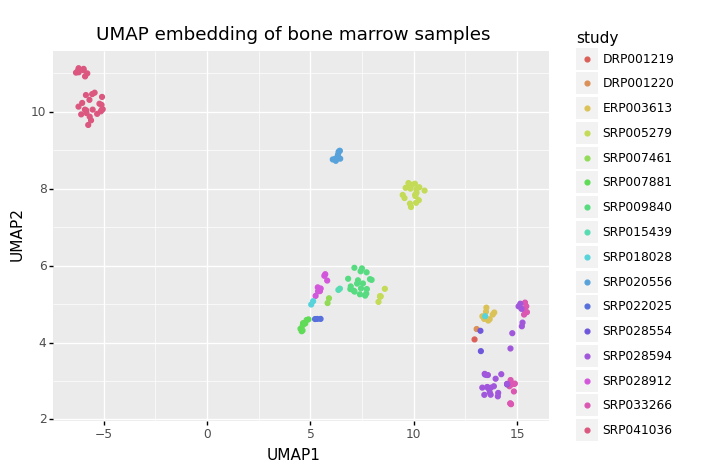

<ggplot: (8752905866333)>


In [163]:
plot = ggplot(umap_df, aes(x='UMAP1', y='UMAP2', color='study'))
plot += geom_point()
plot += ggtitle('UMAP embedding of bone marrow samples')
print(plot)

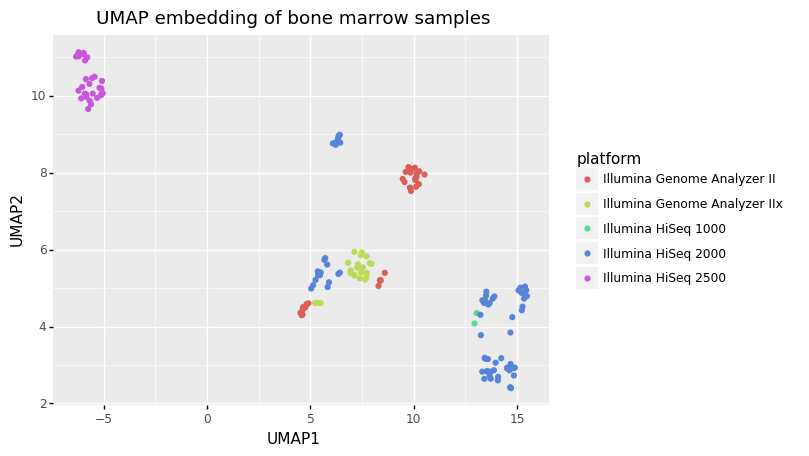

<ggplot: (8752837470381)>


In [176]:
plot = ggplot(umap_df, aes(x='UMAP1', y='UMAP2', color='platform'))
plot += geom_point()
plot += ggtitle('UMAP embedding of bone marrow samples')
print(plot)

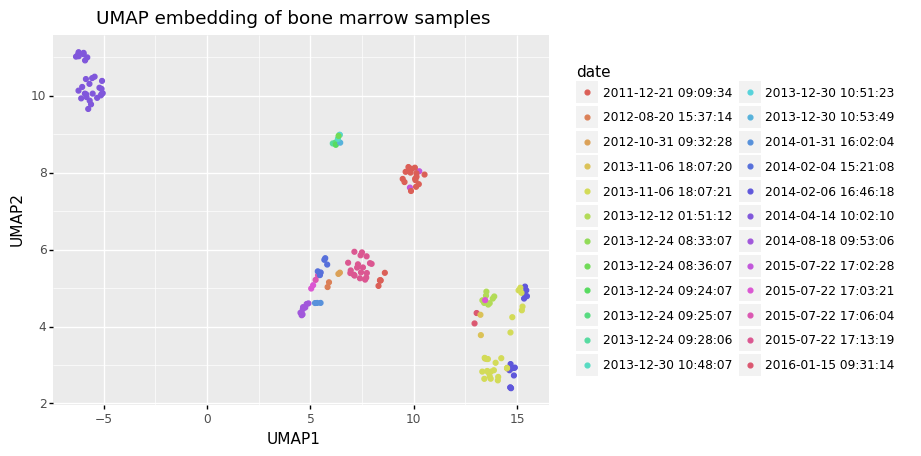

<ggplot: (8752904284593)>


In [196]:
plot = ggplot(umap_df, aes(x='UMAP1', y='UMAP2', color='date'))
plot += geom_point()
plot += ggtitle('UMAP embedding of bone marrow samples')
print(plot)

## Sequencer?
There doesn't seem an expression difference that causes all the bad samples to cluster together, but there does seem to be a disproportionate amount of hard to classify samples from the HiSeq 2000. Does this hold in general/in other tissue types?

In [179]:
hard_df = metadata_df[metadata_df['is_hard']]

In [183]:
hard_df['sra.platform_model'].value_counts()

Illumina HiSeq 2000             228
Illumina Genome Analyzer IIx     55
Illumina Genome Analyzer II      47
Illumina HiSeq 2500              11
Illumina Genome Analyzer          7
Illumina HiSeq 1000               1
Name: sra.platform_model, dtype: int64

In [181]:
hard_df['sra.platform_model'].value_counts() / len(hard_df)

Illumina HiSeq 2000             0.653295
Illumina Genome Analyzer IIx    0.157593
Illumina Genome Analyzer II     0.134670
Illumina HiSeq 2500             0.031519
Illumina Genome Analyzer        0.020057
Illumina HiSeq 1000             0.002865
Name: sra.platform_model, dtype: float64

In [182]:
metadata_df['sra.platform_model'].value_counts() / len(metadata_df)

Illumina HiSeq 2500                                                                                                                                                  0.352234
Illumina HiSeq 2000                                                                                                                                                  0.291082
NextSeq 500                                                                                                                                                          0.165259
Illumina HiSeq 4000                                                                                                                                                  0.089679
Illumina HiSeq 3000                                                                                                                                                  0.017089
Illumina Genome Analyzer IIx                                                                                                      

### Sequencer Results

There seems to be a marked increase in hard-to-classify Hi-seq 2000 samples and decrease in Hi-seq 2500 samples. Is there a reason for this?


In [ ]:
hard_studies = set(hard_df['study'])
hard_study_df = metadata_df[metadata_df['study'].isin(hard_studies)]

In [188]:
hard_study_df['sra.platform_model'].value_counts() 

Illumina HiSeq 2000             1700
Illumina Genome Analyzer II      445
Illumina Genome Analyzer IIx     219
Illumina HiSeq 2500               77
Illumina Genome Analyzer          41
Illumina HiSeq 1000                3
Name: sra.platform_model, dtype: int64

In [190]:
hard_study_df['sra.platform_model'].value_counts() / len(hard_study_df)

Illumina HiSeq 2000             0.684105
Illumina Genome Analyzer II     0.179074
Illumina Genome Analyzer IIx    0.088129
Illumina HiSeq 2500             0.030986
Illumina Genome Analyzer        0.016499
Illumina HiSeq 1000             0.001207
Name: sra.platform_model, dtype: float64

### More sequencer results
The enrichment for Hi-seq 2000 may just be because the studies with hard samples are themselves enriched for Hi-seq 2000. 
The sequencer probably may not be meaningful, but this is still interesting. It feels like the samples are drawn at random from the studies, yielding the given distribution.

Unclear whether this is true though, the studies themselves seem to to be heavily skewed.

## Remaining questions:
- Is it related to sparsity?
- Is there something correlated with sequencer that we'd expect to cause these results?
- Stuff below

In [138]:
# What is the correlation in errors between different runs of the same model?

In [139]:
# Are these correlations affected by the amount of data used?

In [141]:
# To what extent are the relationships caused by label imbalance?

In [142]:
# Does prediction diversity (e.g. guessing all labels instead of just most common) change as amount of data improves? Is this affected by model type?

In [143]:
# Are all labels present in the train set? If not, how does this affect results